# Предсказание температуры сплава

**Описание исследования**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

**Цель исследования**

Разработать решение, которое сможет предсказать температуру сплава для оптимизации потребления электроэнергии.

**Задачи исследования**

Построить модель, которая будет предсказывать температуру сплава. 

**Описание данных**

`data_arc_new.csv` — данные об электродах:
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.
  
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.
  
`data_gas_new.csv` — данные о продувке сплава газом:
- key — номер партии;
- Газ 1 — объём подаваемого газа.
  
`data_temp_new.csv` — результаты измерения температуры:
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.
  
`data_wire_new.csv` — данные о проволочных материалах (объём):
-  key — номер партии;
-  Wire 1 … Wire 9 — объём подаваемых проволочных материалов.
  
`data_wire_time_new.csv` — данные о проволочных материалах (время):
- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

!pip install lightgbm -q
from lightgbm import LGBMRegressor

!pip install shap -q
import shap

TEST_SIZE = 0.25
RANDOM_STATE = 180324

## Загрузка данных

Загрузим данные и выполним их первичный осмотр

In [2]:
try:
    data_arc = pd.read_csv('data_arc_new.csv', parse_dates=[1,2])
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv', parse_dates=[1])
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9])
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv', parse_dates=[1,2])
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv', parse_dates=[1])
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9])

In [3]:
data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [5]:
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [6]:
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [7]:
data_temp.info()
data_temp.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


In [8]:
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Нужно привести названия столбов к стандартному виду.

Нам не важно время, когда загружали легирующие добавки, тем более его сложно визуализировать и использовать эти значения для прогноза не представляется возможным. Дату замера температуры тоже можно убрать, она не несет смысловой нагрузки для построения модели.
Из временных промежутков нам важно время начала и конца нагрева стали. Как вариант создать новый параметр - время нагрева в секундах.

Пропуски в таблицах bulk и wire означают что конкретно данные добавки не использовались, а значит можем смело заменять эти пропуски на 0.

Так же видим пропуски в таблице с замерами температуры, мы здесь не сможем заполнить их, так как это повлияет на итоговый прогноз. Поэтому нужно будет удалить все партии, в которых есть отсутствующие замеры температуры.

## Исследовательский анализ и предобработка данных

Для начала приведем названия столбов к стандартному виду:

In [10]:
data_arc.columns = (x.replace(' ', '_') for x in data_arc.columns)
data_arc.columns = data_arc.columns.str.lower()
data_bulk.columns = (x.replace(' ', '_') for x in data_bulk.columns)
data_bulk.columns = data_bulk.columns.str.lower()
data_bulk_time.columns = (x.replace(' ', '_') for x in data_bulk_time.columns)
data_bulk_time.columns = data_bulk_time.columns.str.lower()
data_gas.columns = (x.replace(' ', '_') for x in data_gas.columns)
data_gas.columns = data_gas.columns.str.lower()
data_temp.columns = (x.replace(' ', '_') for x in data_temp.columns)
data_temp.columns = data_temp.columns.str.lower()
data_wire.columns = (x.replace(' ', '_') for x in data_wire.columns)
data_wire.columns = data_wire.columns.str.lower()
data_wire_time.columns = (x.replace(' ', '_') for x in data_wire_time.columns)
data_wire_time.columns = data_wire_time.columns.str.lower()

Теперь заполним пропуски в таблицах с легирующими добавками:

In [11]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

И избавимся от партий с пропущенными значениями температуры:

In [12]:
data_temp_null = data_temp.query('температура.isnull()')
wrong_keys = data_temp_null['key'].sort_values().unique() #список партий для удаления

data_arc = data_arc.query('~key.isin(@wrong_keys)')
data_bulk = data_bulk.query('~key.isin(@wrong_keys)')
data_bulk_time = data_bulk_time.query('~key.isin(@wrong_keys)')
data_wire = data_wire.query('~key.isin(@wrong_keys)')
data_wire_time = data_wire_time.query('~key.isin(@wrong_keys)')
data_gas = data_gas.query('~key.isin(@wrong_keys)')
data_temp = data_temp.query('~key.isin(@wrong_keys)')

In [13]:
data_arc['активная_мощность'].sort_values().unique()

array([0.223895, 0.228238, 0.228852, ..., 1.444904, 1.458773, 1.463773])

In [14]:
data_arc['реактивная_мощность'].sort_values().unique()

array([-7.15479924e+02,  1.53777000e-01,  1.53921000e-01, ...,
        1.22306300e+00,  1.25862800e+00,  1.27028400e+00])

В наших данных есть аномальное значение реактивной мощности, необходимо удалить партию с этим значением из анализа

In [15]:
data_arc.query('реактивная_мощность == -7.15479924e+02')

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [16]:
data_arc = data_arc.query('key != 2116')
data_bulk = data_bulk.query('key != 2116')
data_bulk_time = data_bulk_time.query('key != 2116')
data_wire = data_wire.query('key != 2116')
data_wire_time = data_wire_time.query('key != 2116')
data_gas = data_gas.query('key != 2116')
data_temp = data_temp.query('key != 2116')

Построим графики визуализации:

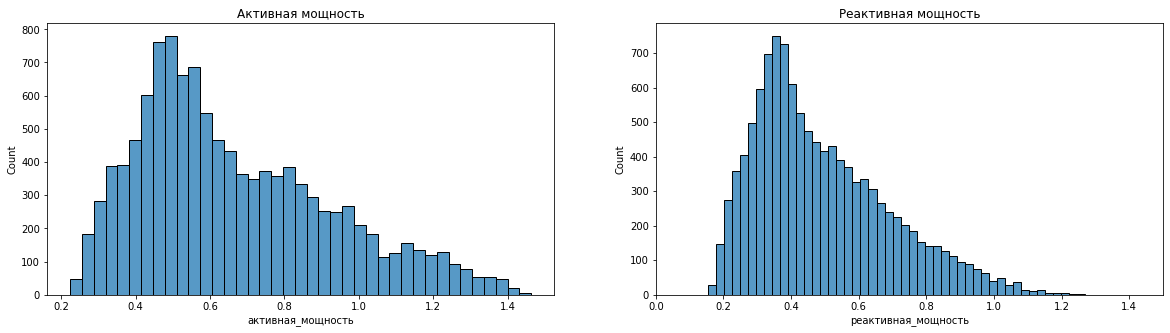

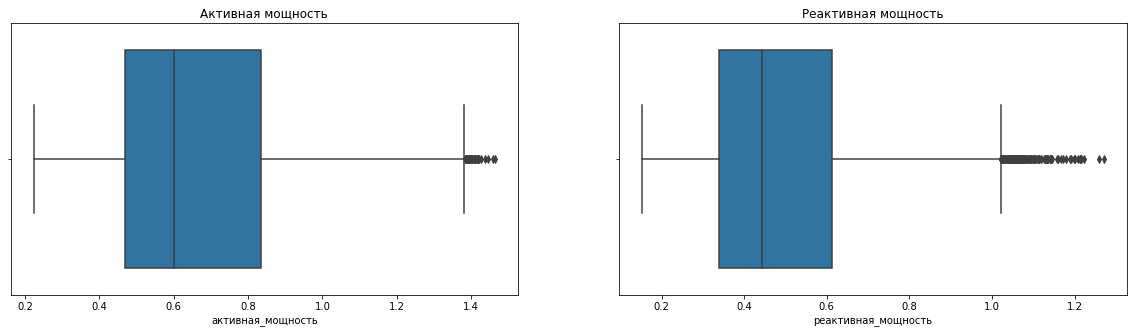

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data_arc['активная_мощность'], ax=axes[0]).set_title('Активная мощность')
sns.histplot(data_arc['реактивная_мощность'], ax=axes[1]).set_title('Реактивная мощность')
plt.xlim(0, 1.5);

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.boxplot(x=data_arc['активная_мощность'], ax=axes[0]).set_title('Активная мощность');
sns.boxplot(x=data_arc['реактивная_мощность'], ax=axes[1]).set_title('Реактивная мощность');

In [18]:
data_arc[['активная_мощность', 'реактивная_мощность']].mean()

активная_мощность      0.665352
реактивная_мощность    0.489736
dtype: float64

В целом графики имеют похожий вид, полезная активная мощность имеет большее среднее значение, что является хорошим результатом, так как вредной реактивной мощности в среднем меньше.

In [19]:
data_arc['начало_нагрева_дугой'].sort_values().unique()

array(['2019-05-03T11:02:14.000000000', '2019-05-03T11:07:28.000000000',
       '2019-05-03T11:11:44.000000000', ...,
       '2019-08-10T13:41:44.000000000', '2019-08-10T13:46:38.000000000',
       '2019-08-10T13:55:06.000000000'], dtype='datetime64[ns]')

In [20]:
data_arc['конец_нагрева_дугой'].sort_values().unique()

array(['2019-05-03T11:06:02.000000000', '2019-05-03T11:10:33.000000000',
       '2019-05-03T11:14:36.000000000', ...,
       '2019-08-10T13:45:09.000000000', '2019-08-10T13:51:33.000000000',
       '2019-08-10T13:56:17.000000000'], dtype='datetime64[ns]')

Данные замеры проходили в течении 4 месяцев - с 3 мая по 10 августа 2019 года.

In [21]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,1250.791442,3.316577,1.376402,46.057333,36.217698,2.554632,21.920233,1.959285,0.020357,0.430411,4.889074,4.107603,209.095970,1.032821,153.740756,116.945160
std,716.543390,12.224364,18.771950,74.619423,58.155923,22.041133,55.185302,30.190928,0.998753,6.119484,20.595391,22.160275,156.242143,14.003687,81.957956,85.582306
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,631.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,1252.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,106.000000
75%,1866.500000,0.000000,0.000000,76.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000
max,2499.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [22]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2372.000000,2372.000000,2372.000000,2372.000000,2372.000000,2372.0,2372.000000,2372.000000,2372.000000,2372.000000
mean,1250.736509,102.274529,17.856377,3.176273,0.300993,0.0,0.961076,0.006245,0.305667,0.414319
std,716.023194,43.637735,33.944219,27.691693,4.714583,0.0,8.615099,0.203833,4.362799,4.331678
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,628.750000,72.859018,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1253.500000,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.250000,128.143076,23.162880,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,90.053604


Большинство легирующих добавок имеют очень низкие средние значения, значит они не так часто добавлялись к стали. Проволочная добавка wire_5 вообще не использовалась - этот столбец можно смело удалять.

In [23]:
data_wire = data_wire.drop(['wire_5'], axis=1)
data_wire_time = data_wire_time.drop(['wire_5'], axis=1)

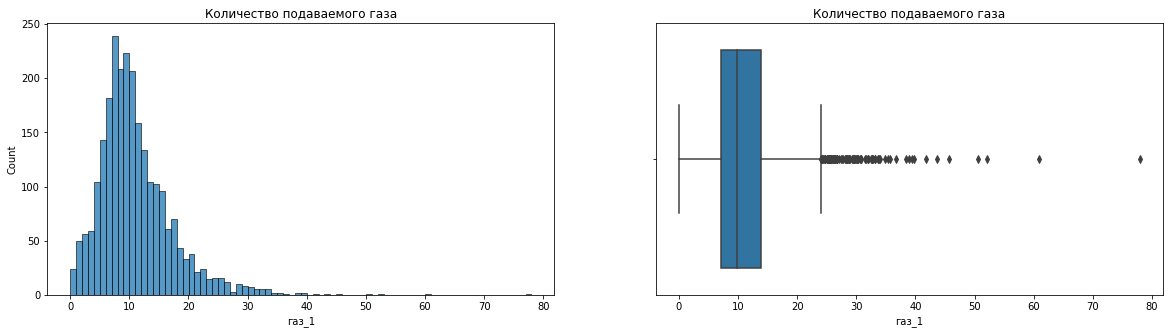

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data_gas['газ_1'], ax=axes[0]).set_title('Количество подаваемого газа');
sns.boxplot(x=data_gas['газ_1'], ax=axes[1]).set_title('Количество подаваемого газа');

В таблице подаваемого газа очень много выбросов, при этом среднее значение около 10.

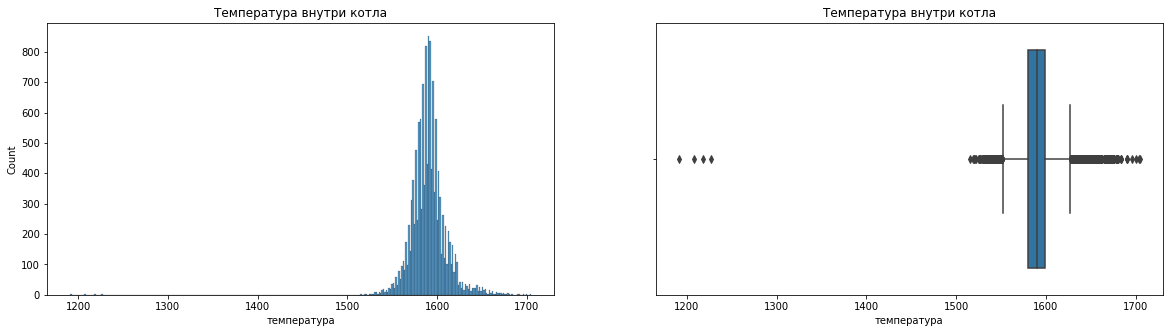

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data_temp['температура'], ax=axes[0]).set_title('Температура внутри котла')
sns.boxplot(x=data_temp['температура'], ax=axes[1]).set_title('Температура внутри котла');

Температура в среднем равна 1550, при этом есть пара выборосов когда она равна 1200.

Найдем и удалим партии с аномальными значениями температур:

In [26]:
data_temp.query('температура < 1300')['key']

4883      867
6784     1214
9050     1619
11495    2052
Name: key, dtype: int64

В 4 партиях есть температуры ниже 1300, удалим их из таблиц:

In [27]:
bad_keys = data_temp.query('температура < 1300')['key']

data_arc = data_arc.query('~key.isin(@bad_keys)')
data_bulk = data_bulk.query('~key.isin(@bad_keys)')
data_bulk_time = data_bulk_time.query('~key.isin(@bad_keys)')
data_wire = data_wire.query('~key.isin(@bad_keys)')
data_wire_time = data_wire_time.query('~key.isin(@bad_keys)')
data_gas = data_gas.query('~key.isin(@bad_keys)')
data_temp = data_temp.query('~key.isin(@bad_keys)')

Мы избавились от пропусков в данных и удалили партии, которые не несут смысловой нагрузки для нашего анализа. 

В целом в данных имеются выбросы, но их удаление не является обязательным действием, скорее всего это редкие обстоятельства, которые действительно могут случаться. Необходимость избавления от выбросов мы рассмотрим в ходе построения модели, если нас не устроит метрика можно будет задуматься над очисткой наших данных.

## Объединение данных

Таблицы с временными промежутками нам не нужны. Остальные таблицы объединим в один датафрейм по столбцу `key`.

Прежде всего создадим новый признак - время нагрева в секундах:

In [28]:
data_arc['время_нагрева_сек'] = (data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']).dt.seconds

Объединим столбцы активной и реактивной мощностей и создадим новый признак полная мощность. Для этого воспользуемся формулой полной мощности:

In [29]:
data_arc['полная_мощность'] = np.sqrt(data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)

Теперь займемся объединением всех итераций внутри одной партии в одно значение. Для этого найдем суммарные значения для каждой партии:

In [30]:
data_arc2 = data_arc.drop(['начало_нагрева_дугой', 'конец_нагрева_дугой', 'активная_мощность', 'реактивная_мощность'], axis=1)
data_arc2.head()

,key,время_нагрева_сек,полная_мощность
0,1,228,0.371123
1,1,185,0.902319
2,1,172,0.722536
3,1,365,0.642824
4,1,148,1.079934


In [31]:
arc = data_arc2.groupby(by='key').agg(['sum'])
arc.columns = ['sum_время_нагрева_сек', 'sum_полная_мощность']

In [32]:
arc.head()

,sum_время_нагрева_сек,sum_полная_мощность
key,,
1,1098,3.718736
2,811,2.588349
3,655,5.019223
4,741,3.400038
5,869,2.816980


Из таблицы с замерами температуры нужно выделить целевой признак финального замера, также выделим начальную температуру до нагрева:

In [33]:
data_temp2 = data_temp.drop(['время_замера'], axis=1)

In [34]:
temp = data_temp2.groupby(by='key').agg(['first', 'last']).astype(np.int64)
temp.columns = ['температура_до', 'температура_после']

In [35]:
temp.head()

,температура_до,температура_после
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602


Наконец объеденим все таблицы по столбцу `key`:

In [36]:
data = arc.merge(temp, on=['key'])
data = data.merge(data_gas, on=['key'])
data = data.merge(data_bulk, on=['key'])
data = data.merge(data_wire, on=['key'])

In [37]:
data.head()

,key,sum_время_нагрева_сек,sum_полная_мощность,температура_до,температура_после,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,...,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1098,3.718736,1571,1613,29.749986,0.0,0.0,0.0,43.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,2.588349,1581,1602,12.555561,0.0,0.0,0.0,73.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,5.019223,1596,1599,28.554793,0.0,0.0,0.0,34.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,3.400038,1601,1625,18.841219,0.0,0.0,0.0,81.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,2.816980,1576,1602,5.413692,0.0,0.0,0.0,78.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


Мы создали новую таблицу, в которой выделен целевой признак в отдельном столбце. Так же мы добавили новый признак с временем нагрева и признак полной мощности.

Дальше займемся анализом нашей новой таблицы и выполним при необходимости ее предобработку.

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [38]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   int64  
 1   sum_время_нагрева_сек  2324 non-null   int64  
 2   sum_полная_мощность    2324 non-null   float64
 3   температура_до         2324 non-null   int64  
 4   температура_после      2324 non-null   int64  
 5   газ_1                  2324 non-null   float64
 6   bulk_1                 2324 non-null   float64
 7   bulk_2                 2324 non-null   float64
 8   bulk_3                 2324 non-null   float64
 9   bulk_4                 2324 non-null   float64
 10  bulk_5                 2324 non-null   float64
 11  bulk_6                 2324 non-null   float64
 12  bulk_7                 2324 non-null   float64
 13  bulk_8                 2324 non-null   float64
 14  bulk_9                 2324 non-null   float64
 15  bulk

,key,sum_время_нагрева_сек,sum_полная_мощность,температура_до,температура_после,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,...,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1098,3.718736,1571,1613,29.749986,0.0,0.0,0.0,43.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,2.588349,1581,1602,12.555561,0.0,0.0,0.0,73.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,5.019223,1596,1599,28.554793,0.0,0.0,0.0,34.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,3.400038,1601,1625,18.841219,0.0,0.0,0.0,81.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,2.816980,1576,1602,5.413692,0.0,0.0,0.0,78.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


Перенесем столбец key в индексы:

In [39]:
data = data.set_index('key')

In [40]:
pd.set_option('max_columns', None)
data.describe()

,sum_время_нагрева_сек,sum_полная_мощность,температура_до,температура_после,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,808.196644,3.886143,1587.368761,1593.372633,11.378854,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.021084,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313,102.423900,17.613213,3.241876,0.307209,0.980926,0.006374,0.311981,0.317795
std,340.813828,1.517584,23.627590,11.207457,6.397008,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,1.016431,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967,43.540975,33.648176,27.972523,4.762842,8.702531,0.205926,4.407419,3.460248
min,57.000000,0.331897,1519.000000,1541.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,581.000000,2.846893,1571.000000,1587.000000,7.282534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,73.204559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,778.000000,3.770584,1587.000000,1593.000000,10.100687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,101.103600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,993.000000,4.769753,1603.000000,1598.000000,14.218487,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,128.075222,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4189.000000,15.288271,1660.000000,1653.000000,77.995040,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


Большинство средних значений легирующих добавок находится у отметки 0, для построения модели некоторые из них нужно будет убрать из входных признаков. Для более точного вывода нужно построить матрицу корреляции.

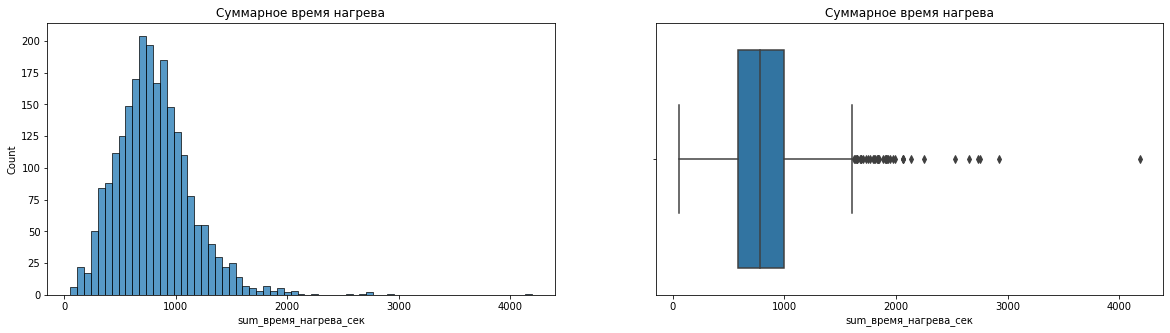

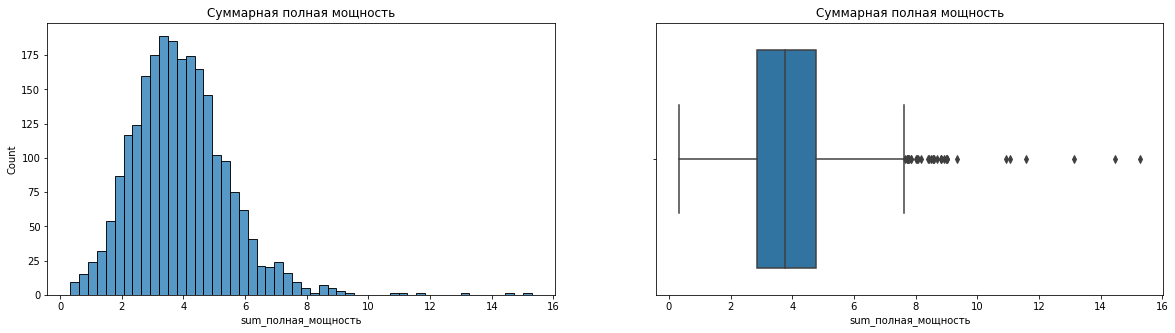

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data['sum_время_нагрева_сек'], ax=axes[0]).set_title('Суммарное время нагрева');
sns.boxplot(x=data['sum_время_нагрева_сек'], ax=axes[1]).set_title('Суммарное время нагрева');

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data['sum_полная_мощность'], ax=axes[0]).set_title('Суммарная полная мощность');
sns.boxplot(x=data['sum_полная_мощность'], ax=axes[1]).set_title('Суммарная полная мощность');

Некоторые партии требовали большего времени нагрева, что может быть связанно с большим количеством итераций добавления добавок, из-за этого и полной мощности требовалось больше на некоторые партии.

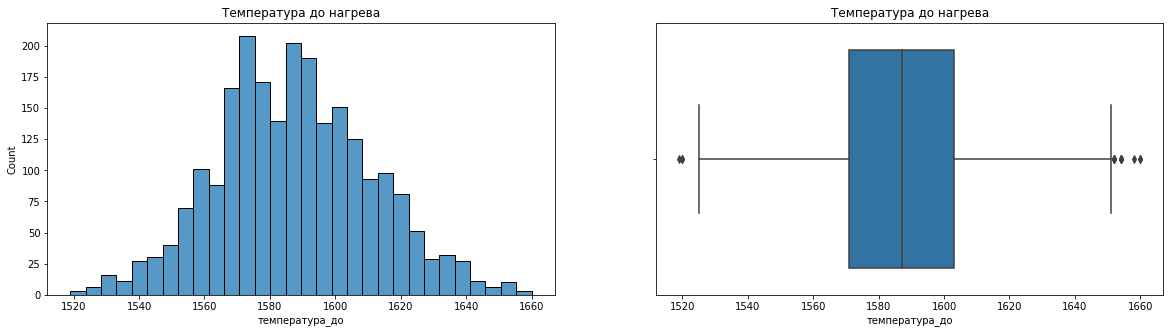

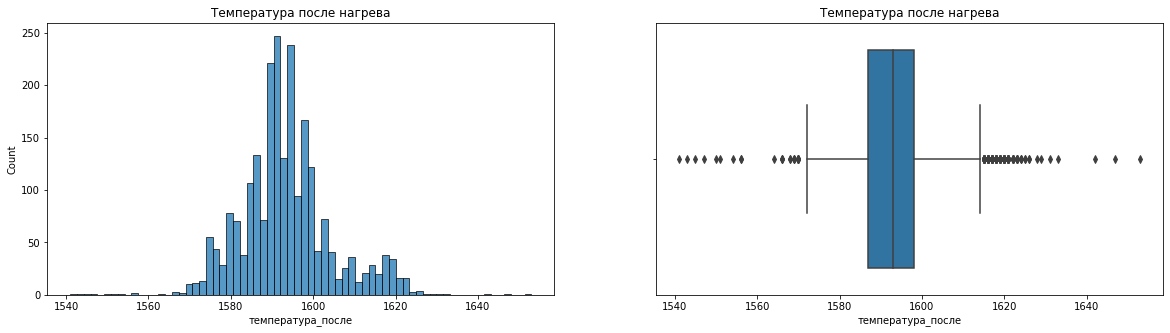

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data['температура_до'], ax=axes[0]).set_title('Температура до нагрева');
sns.boxplot(x=data['температура_до'], ax=axes[1]).set_title('Температура до нагрева');

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data['температура_после'], ax=axes[0]).set_title('Температура после нагрева');
sns.boxplot(x=data['температура_после'], ax=axes[1]).set_title('Температура после нагрева');

В целом, средние температуры до и после нагрева имеют близкие значения.

Так же видим что финальная температура в некоторых партиях превышает 1620 градусов, что возможно говорит о необходимости оптимизации в производстве.

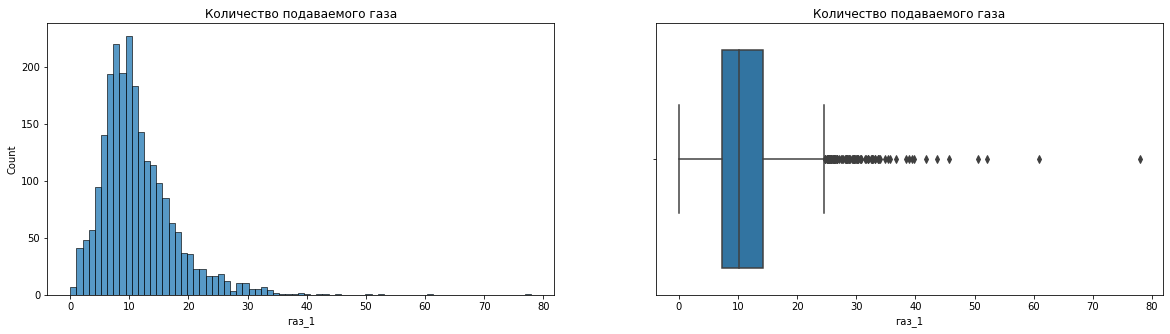

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(data['газ_1'], ax=axes[0]).set_title('Количество подаваемого газа');
sns.boxplot(x=data['газ_1'], ax=axes[1]).set_title('Количество подаваемого газа');

Количество газа в среднем составляет 10 единиц, большие значения говорят о партиях с большим количеством итераций.

Все признаки количественные, поэтому можно использовать корреляцию Пирсона:

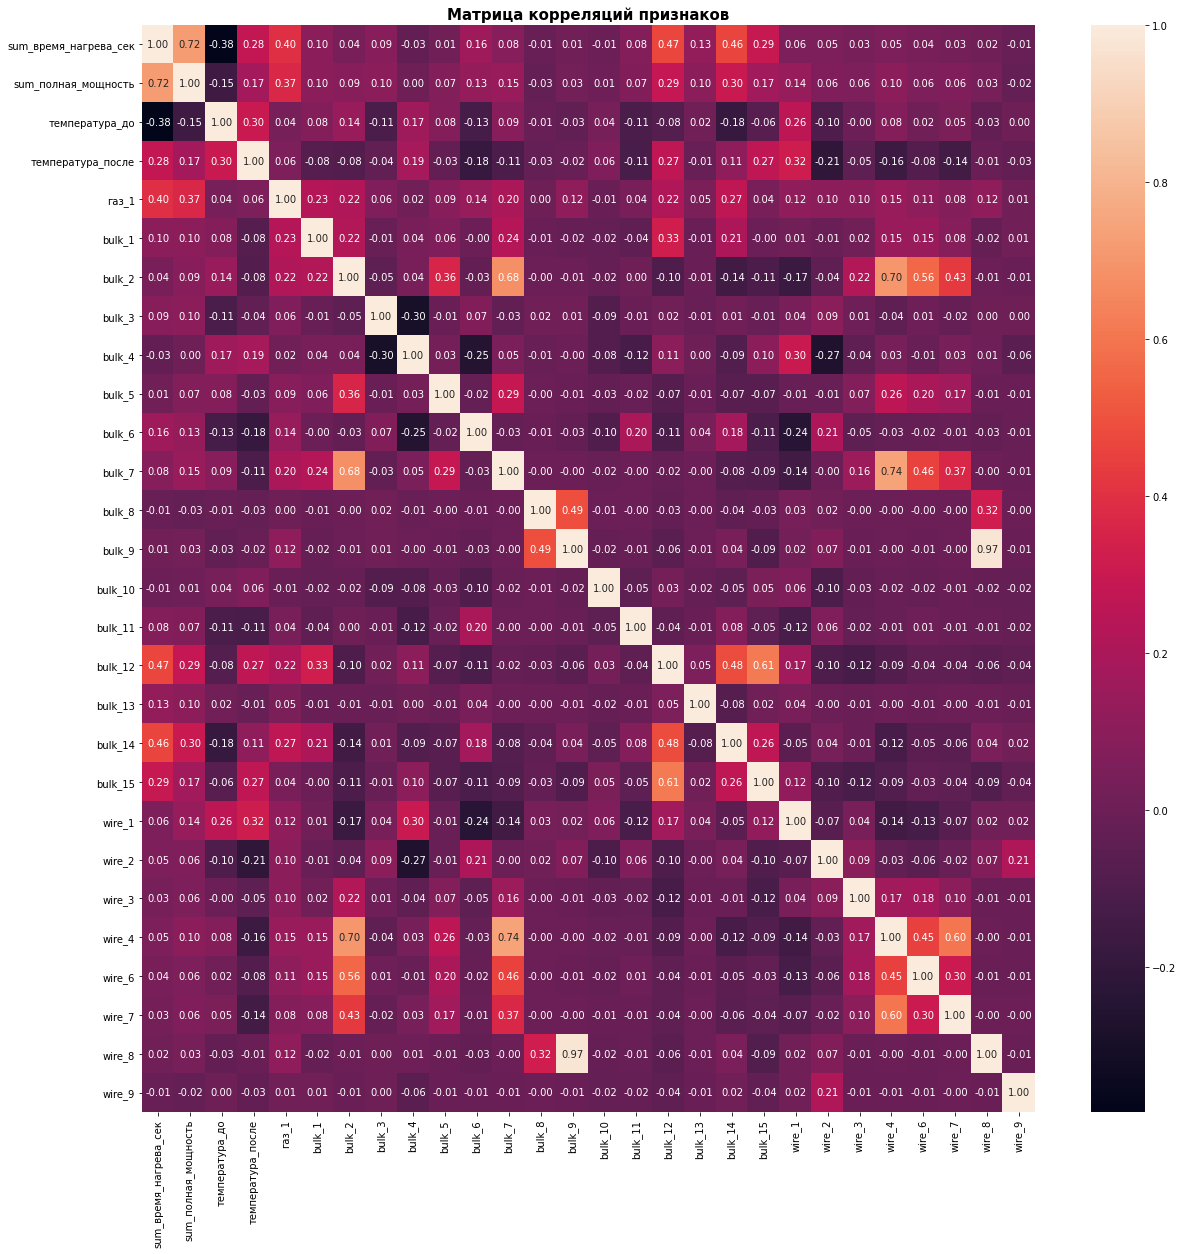

In [45]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.title('Матрица корреляций признаков', fontsize= 15, fontweight='bold', loc='center');

Имеем мультиколлинеарность между wire_8 и bulk_9, поэтому удалим один из этих признаков bulk_9:

In [46]:
data2 = data.drop(['bulk_9'], axis=1)

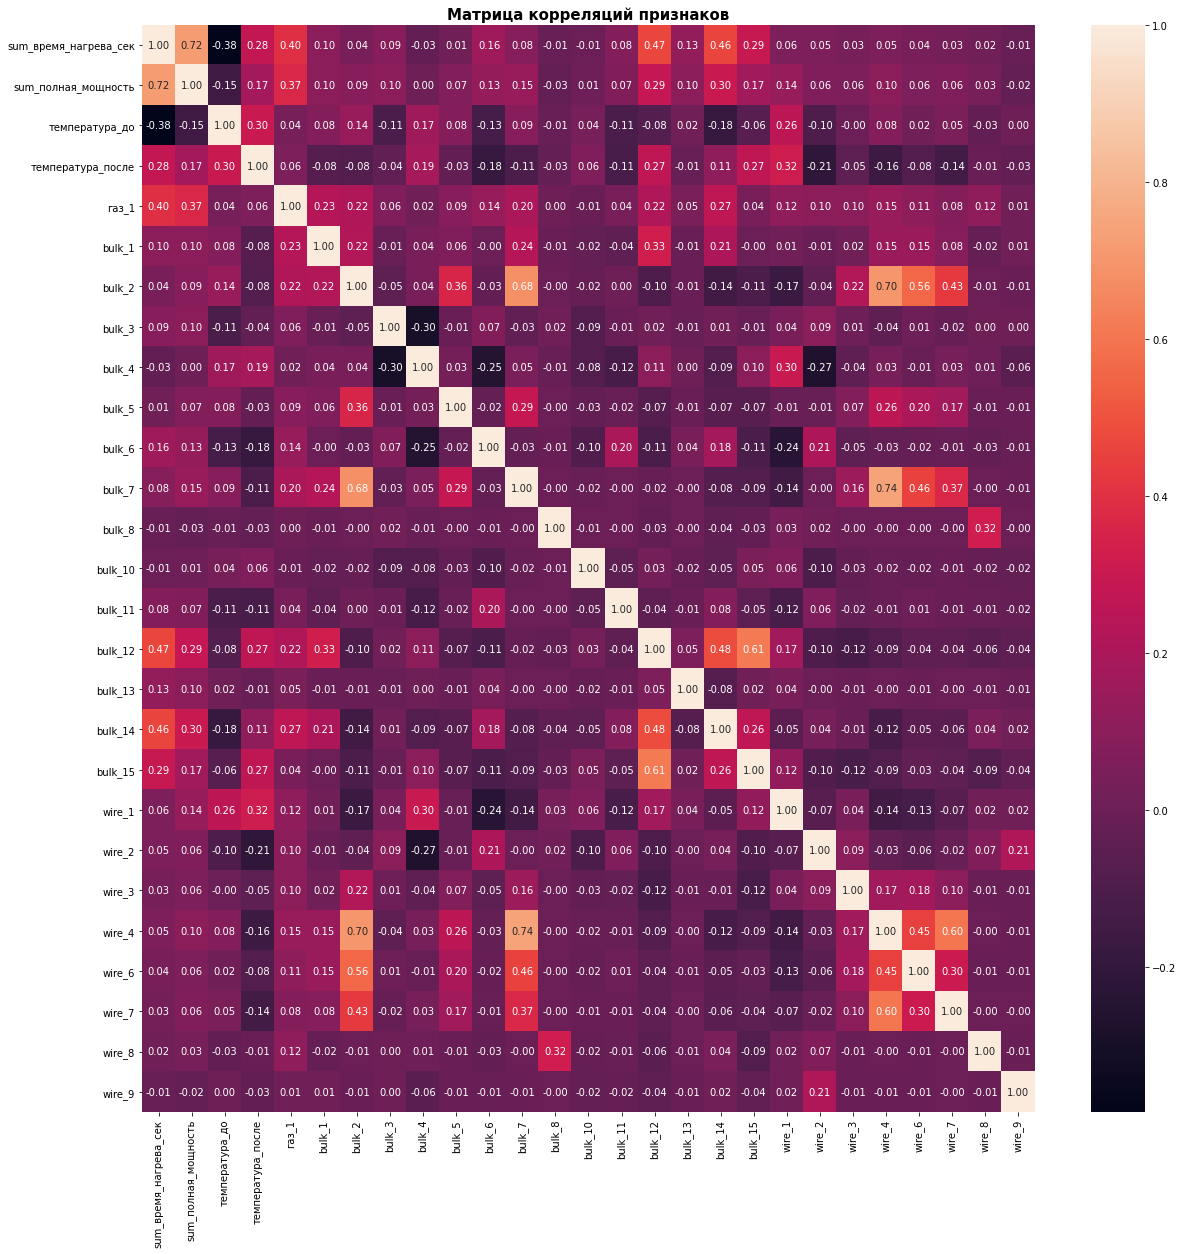

In [48]:
plt.figure(figsize=(20, 20))
sns.heatmap(data2.corr(), annot=True, fmt='.2f')
plt.title('Матрица корреляций признаков', fontsize= 15, fontweight='bold', loc='center');

После удаления признака bulk_9 мы избавились от мультиколлинеарности.

Мы провели анализ новых данных, сгруппированных по партиям, также мы избавились от признаков не влиящих на целевой признак.

Дальше займемся подготовкой данных для обучения.

## Подготовка данных

Разделим данные на две выборки:

In [49]:
X = data2.drop(['температура_после'], axis=1)
y = data2['температура_после']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

num_columns = list(X)

Подготовим пайплайн с масштабированием и моделью:

In [50]:
data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_columns)],
    remainder='passthrough')

pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

## Обучение моделей машинного обучения

Обучим две модели DecisionTreeRegressor и LGBMRegressor, подберем для каждой из них гиперпараметры. Метрикой для проверки будем использовать MAE, при этом критерием проверки является значение MAE не более 6.8

In [51]:
param_distributions = [
    { 
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)], 
        'models__max_depth': range(2,6), 
        'models__min_samples_split' : range(2,6)
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,6),
        'models__num_leaves': range(2,6)
    }
] 

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_mean_absolute_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_) 

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['sum_время_нагрева_сек',
                                                   'sum_полная_мощность',
                                                   'температура_до', 'газ_1',
                                                   'bulk_1', 'bulk_2', 'bulk_3',
                                                   'bulk_4', 'bulk_5', 'bulk_6',
                                                   'bulk_7', 'bulk_8',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'wire_1', 'wire_2', 'wire_3',
                                        

In [52]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика MAE для лучшей модели: {abs(randomized_search.best_score_)}')

Метрика MAE для лучшей модели: 6.32344323060274


В ходе обучения лучшей моделью стала LGBMRegressor с параметрами max_depth=4, num_leaves=5 и метрика имеет отличное значение меньше 6.8. Для окончательного выбора рассмотрим все полученные результаты и выберем лучшую модель.

## Выбор лучшей модели

Рассмотрим все найденные модели с параметрами:

In [53]:
cv_results = pd.DataFrame(randomized_search.cv_results_)[['mean_test_score', 'mean_fit_time','mean_score_time', 'param_models', 'params']]
cv_results['mean_test_score'] = cv_results['mean_test_score'] *(-1)
cv_results.sort_values(by='mean_test_score')

,mean_test_score,mean_fit_time,mean_score_time,param_models,params
6,6.323443,13.775835,0.077591,"LGBMRegressor(max_depth=4, num_leaves=5, rando...","{'models__num_leaves': 5, 'models__max_depth':..."
2,6.420689,8.917487,0.094240,"LGBMRegressor(max_depth=4, num_leaves=5, rando...","{'models__num_leaves': 3, 'models__max_depth':..."
3,6.420689,6.939143,0.078180,"LGBMRegressor(max_depth=4, num_leaves=5, rando...","{'models__num_leaves': 3, 'models__max_depth':..."
9,6.420689,7.552116,0.061789,"LGBMRegressor(max_depth=4, num_leaves=5, rando...","{'models__num_leaves': 3, 'models__max_depth':..."
7,6.514586,5.217028,0.060536,"LGBMRegressor(max_depth=4, num_leaves=5, rando...","{'models__num_leaves': 2, 'models__max_depth':..."
0,7.270783,0.011726,0.004629,DecisionTreeRegressor(random_state=180324),"{'models__min_samples_split': 4, 'models__max_..."
8,7.306303,0.021900,0.003062,DecisionTreeRegressor(random_state=180324),"{'models__min_samples_split': 3, 'models__max_..."
1,7.541041,0.010222,0.003300,DecisionTreeRegressor(random_state=180324),"{'models__min_samples_split': 4, 'models__max_..."
4,7.541041,0.009388,0.002848,DecisionTreeRegressor(random_state=180324),"{'models__min_samples_split': 2, 'models__max_..."
5,7.690081,0.012159,0.003005,DecisionTreeRegressor(random_state=180324),"{'models__min_samples_split': 2, 'models__max_..."


In [54]:
cv_results['param_models'] = cv_results['param_models'].astype('category')
first = cv_results.groupby('param_models')['mean_test_score'].min()[0]
second = cv_results.groupby('param_models')['mean_test_score'].min()[1]
pd.concat([cv_results.query('mean_test_score == @first'),cv_results.query('mean_test_score == @second')])

,mean_test_score,mean_fit_time,mean_score_time,param_models,params
0,7.270783,0.011726,0.004629,DecisionTreeRegressor(random_state=180324),"{'models__min_samples_split': 4, 'models__max_..."
6,6.323443,13.775835,0.077591,"LGBMRegressor(max_depth=4, num_leaves=5, rando...","{'models__num_leaves': 5, 'models__max_depth':..."


Метрика для модели DecisionTreeRegressor не соответствует условию, она больше чем 6.8. Поэтому лучшей моделью остается LGBMRegressor с параметрами max_depth=4, num_leaves=5 со значением метрики на тренировочных данных 6.32.

Найдем значение метрики на тестовой выборке:

In [55]:
print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, y_test_pred)}')

Метрика MAE на тестовой выборке: 6.200056440783773


На тесте модель показала результат еще лучше, со значением 6.2 что меньше требуемых 6.8.

Но для окончательного результата проверим модель на адекватность, сравнив с моделью DummyRegressor:

In [56]:
pipe_dummy = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DummyRegressor())])

pipe_dummy.fit(X_train, y_train) 

dummy_pred = pipe_dummy.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {mean_absolute_error(y_test, dummy_pred)}') 

Метрика RMSE на тестовой выборке: 7.930183482886547


Модель DummyRegressor получила метрику 7.93, что не соответсвуют нашему требованию и это гораздо больше чем результат полученный моделью LGBMRegressor.

Итогом лучшей моделью становится LGBMRegressor с параметрами max_depth=4, num_leaves=5. 

Теперь перейдем к выделению важности признаков, для этого будем использовать SHAP:

In [57]:
pipe_num = randomized_search.best_estimator_['preprocessor'].transformers[0][1]
X_shap = pd.DataFrame(pipe_num.fit_transform(X_train[num_columns]), columns = num_columns)
explainer = shap.Explainer(randomized_search.best_estimator_['models'].predict, X_shap)

PermutationExplainer explainer: 1744it [23:27,  1.23it/s]                          


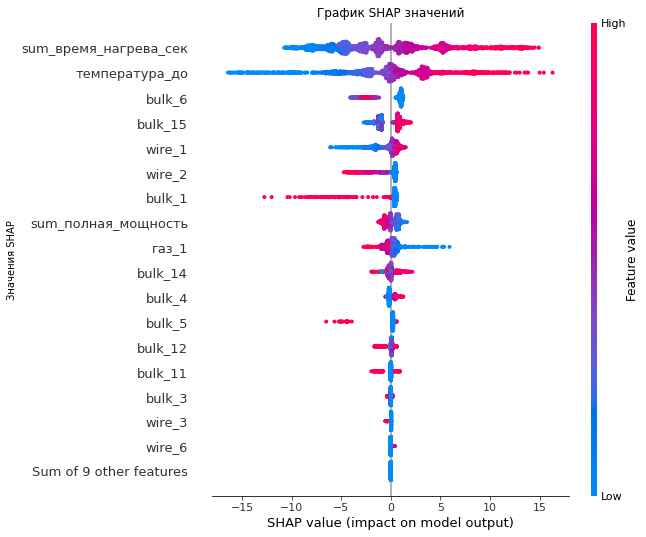

In [58]:
shap_values = explainer(X_shap)
shap.plots.beeswarm(shap_values, max_display=18, show=False)
plt.title('График SHAP значений')
plt.ylabel('Значения SHAP')
plt.show()

Наиболее важными признаками являются общее время нагрева и начальная температура. Чем дольше проходил нагрев и чем выше была начальная температура, тем выше финальная температура. Верно и обратное при меньшем времени нагрева и низкой начальной температуре - финальная температура будет ниже.

Так же на температуру влияет количество подаваемого газа, что и логично, при подаче большего количества газа итоговая температура снижается.

Среди легирующих добавок наиболее значимой является bulk_1, чем меньше ее добавляли, тем выше была финальная температура.

## Общий вывод

В ходе нашего исследования мы разработали решение, которое предсказывает температуру сплава.

Предоставленные нам замеры температуры  проходили в течении 4 месяцев - с 3 мая по 10 августа 2019 года.

В ходе предобработки мы:

- Привели названия столбов к стандартному виду
- Заполнили пропуски в таблицах с легирующими добавками и заменили их на 0
- Удалили все партии, в которых есть отсутствующие значения температур.
- Избавились от партии с аномальным значением реактивной мощности
- Удалили столбец wire_5, этот столбец имел полностью нулевые значения, проволока данного типа не использовалась как добавка
- Удалили партии, в которых температура имела значения меньше 1300 градусов

В ходе анализа мы получили, что:

- Полезная активная мощность имеет большее среднее значение, что является хорошим результатом, так как вредной реактивной мощности в среднем меньше.
- Большинство легирующих добавок имеют очень низкие средние значения, значит они не так часто добавлялись к стали. 
- В таблице подаваемого газа очень много выбросов, при этом среднее значение около 10.
- Температура в среднем равна 1550, при этом есть пара выбросов, когда она меньше 1300.

Для построения модели мы создали новую таблицу, в которую добавили целевой признак для каждой партии с температурой после всех итераций изменения стали.

Мы не учитывали таблицы wire_time и bulk_time с временами внесения добавок, остальные таблицы мы объединили по общему столбцу номера партии key, при этом мы:

- Создали новый признак - время нагрева в секундах
- Объединили столбцы активной и реактивной мощностей и создали новый признак полная мощность
- Для объединения всех итераций каждой партии мы посчитали суммарные значения полной мощности и времени нагрева
- Выделили целевой признак финального замера температуры в каждой партии, также выделили начальную температуру до нагрева

В ходе предобработки новой таблицы мы:

- Перенесли столбец key в индексы
- Удалили из таблицы столбец bulk_9 для избавления от мультиколлинеарности

В ходе анализа новой таблицы мы получили, что:

- Некоторые партии требовали большего времени нагрева, что может быть связанно с большим количеством итераций добавления добавок, из-за этого и полной мощности требовалось больше на некоторые партии.
- В целом, средние температуры до и после нагрева имеют близкие значения. Финальная температура в некоторых партиях превышает 1620 градусов.
- Количество газа в среднем составляет 10 единиц, большие значения говорят о партиях с большим количеством итераций.
- Имеем взаимную мультиколлинеарность у признаков bulk_9 и wire_8.

Для подготовки построения модели мы разделили данные на две выборки - 75% тренировочная и 25% тестовая, и создали пайплайн с масштабированием и моделью.

Мы обучали две модели DecisionTreeRegressor и LGBMRegressor, и подбирали для каждой из них гиперпараметры. Метрикой для проверки использовали MAE, при этом критерием проверки было значение MAE не более 6.8.

На тренировочных данных метрика для модели DecisionTreeRegressor не соответствовала условию и была больше, чем 6.8. Поэтому лучшей моделью была выбрана LGBMRegressor с параметрами max_depth=4, num_leaves=5 со значением метрики на тренировочных данных 6.32.

На тестовых данных модель LGBMRegressor получила метрику 6.2. Для проверки модели LGBMRegressor на адекватность, мы использовали модель DummyRegressor, она получила метрику 7.93, что подтвердило правильность нашего выбора.

По итогу лучшей моделью выбрана LGBMRegressor с параметрами max_depth=4, num_leaves=5 и метрикой MAE 6.2.

Наиболее важными признаками являются общее время нагрева и начальная температура. Чем дольше проходил нагрев и чем выше была начальная температура, тем выше финальная температура. Верно и обратное при меньшем времени нагрева и низкой начальной температуре - финальная температура будет ниже. Так же на температуру влияет количество подаваемого газа, при подаче большего количества газа итоговая температура снижается. Среди легирующих добавок наиболее значимой является bulk_1, чем меньше ее добавляли, тем выше была финальная температура.

Металлургический комбинат «Стальная птица» сможет контролировать температуру сплава для уменьшения потребления электроэнергии на этапе обработки стали.
Рекомендацией для комбината разобраться в причинах неиспользования добавки wire_5. Так же на производстве прибор для измерения температуры явно имеет дефекты, из-за которых не для всех партий были измерены температуры. Поэтому главной задачей перед применением нашей модели будет замена прибора для измерения температуры.